In [1]:
# %matplotlib notebook
# %matplotlib inline
import numpy as np
np.random.seed(123)
import collections, copy, pickle
from importlib import reload
from dateutil.parser import parse
import scipy.linalg, scipy.stats
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14
# rcParams['text.usetex'] = True
import seaborn as sns
from IPython.display import HTML
# from numba import jit, njit, float32, prange
# import cProfile

In [2]:
import util.plot
import util.data

In [3]:
reload(util.plot)
reload(util.data)

<module 'util.data' from '/Users/mark/stack/doc/school/Data Mining Techniques/lab/util/data.py'>

In [4]:
data = pd.read_csv('ODI-2019-csv.csv', sep=';')

In [5]:
for i in range(len(data.index)):
    n = data.iloc[i].isnull().sum()
    if n > 0:
        print("Nan in row ", i ,  data.keys()[i])

Nan in row  0 Timestamp


In [6]:
# key = 'What programme are you in?'
# data[data[key].isin(['CLS','COMPUTATIONAL SCIENCE'])]

There is a single missing value (in the first row)

In [7]:
data.iloc[0][-1:]

What is your stress level (0-100)?    NaN
Name: 0, dtype: object

Generate a clean db with
```
python3 clean_odi.py
```

In [8]:
# %ls

In [9]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [10]:
data.describe()

,Unnamed: 0,Stress level,Day,Month,Year,Neighbours,Money,Bedtime
count,276.000000,276.000000,262.000000,262.000000,200.000000,261.000000,276.000000,271.000000
mean,137.500000,38.500000,14.877863,6.419847,1994.110000,4.877395,35.241884,8.158672
std,79.818544,33.933571,8.495681,3.411619,2.985375,8.174556,40.238578,3.401621
min,0.000000,0.000000,0.000000,0.000000,1971.000000,0.000000,0.000000,1.000000
25%,68.750000,10.000000,8.000000,4.000000,1993.000000,2.000000,1.000000,6.000000
50%,137.500000,30.000000,15.000000,6.000000,1995.000000,3.000000,10.000000,7.000000
75%,206.250000,65.000000,21.000000,9.000000,1996.000000,6.000000,80.000000,9.000000
max,275.000000,100.000000,31.000000,12.000000,2001.000000,80.000000,100.000000,20.000000


In [11]:
data.head()

,Unnamed: 0,Timestamp,ML,IR,Stat,DB,Gender,Chocolate,Stand Up,Rand,Good day (1),Good day (2),Stress level,Programme,Day,Month,Year,Neighbours,Money,Bedtime
0,0,3/27/2019 10:16:11,Yes,Yes,Yes,Yes,unknown,Slim,no,6,sun,lecture,30.0,AI,NaN,NaN,NaN,3.0,100.0,6.0
1,1,4/1/2019 15:58:21,No,No,Yes,Yes,male,Fat,no,7,DM,AI,1.0,AI,9.0,7.0,1992.0,1.0,0.0,10.0
2,2,4/1/2019 15:59:07,Yes,Yes,Unknown,Yes,male,Neither,unknown,0,0,0,100.0,CS,4.0,8.0,1995.0,0.0,0.0,7.0
3,3,4/1/2019 15:59:30,Yes,Yes,Yes,Yes,male,Fat,no,"1,645",Winning,Food,0.0,CS,29.0,9.0,1993.0,2.0,42.0,7.0
4,4,4/1/2019 15:59:58,No,Yes,Yes,Yes,male,Neither,no,66,kiss,love,100.0,CS,17.0,4.0,NaN,2.0,10.0,3.0


In [12]:
# categorical = ['Program','ML','IR','DB','Stat']
numerical = ['Year', 'Money', 'Neighbours', 'Stress level', 'Bedtime']
categorical = list(data.keys())
for label in numerical:
    categorical.remove(label)
# irrelevant
categorical.remove('Timestamp')
categorical.remove('Unnamed: 0')
categorical.remove('Month')
categorical.remove('Day')
categorical.remove('Rand') # numerical & noisy
# categorical.remove('Bedtime') # numerical & noisy
# too many categories
categorical.remove('Good day (1)')
categorical.remove('Good day (2)')
categorical.remove('Programme')
categorical

['ML', 'IR', 'Stat', 'DB', 'Gender', 'Chocolate', 'Stand Up']

In [13]:
for k in numerical:
    v = data[k]
    print('%s & %.2f & %.2f & %.2f & %.2f & %.2f \\\\' % (k, v.mean(), v.median(), v.std(), v.min(), v.max()))

Year & 1994.11 & 1995.00 & 2.99 & 1971.00 & 2001.00 \\
Money & 35.24 & 10.00 & 40.24 & 0.00 & 100.00 \\
Neighbours & 4.88 & 3.00 & 8.17 & 0.00 & 80.00 \\
Stress level & 38.50 & 30.00 & 33.93 & 0.00 & 100.00 \\
Bedtime & 8.16 & 7.00 & 3.40 & 1.00 & 20.00 \\


In [14]:
# x = np.random.random(9) *2
# sns.distplot(x)

In [15]:
(np.array([20, 23, 2]) - 17) % 24, 5 + 9

(array([3, 6, 9]), 14)

Year ~ Money: 	 not significant 	 p-value: 0.6036, c: 0.0369
Year ~ Neighbours: 	 not significant 	 p-value: 0.9638, c: -0.0033
Year ~ Stress level: 	 not significant 	 p-value: 0.5682, c: -0.0406
Year ~ Bedtime: 	 not significant 	 p-value: 0.7614, c: -0.0217
Money ~ Neighbours: 	 significant 	 p-value: 0.0372, c: 0.1290
Money ~ Stress level: 	 not significant 	 p-value: 0.2877, c: -0.0642
Money ~ Bedtime: 	 not significant 	 p-value: 0.7748, c: 0.0175
Neighbours ~ Stress level: 	 not significant 	 p-value: 0.2111, c: 0.0777
Neighbours ~ Bedtime: 	 not significant 	 p-value: 0.9802, c: 0.0016
Stress level ~ Bedtime: 	 not significant 	 p-value: 0.4850, c: 0.0426


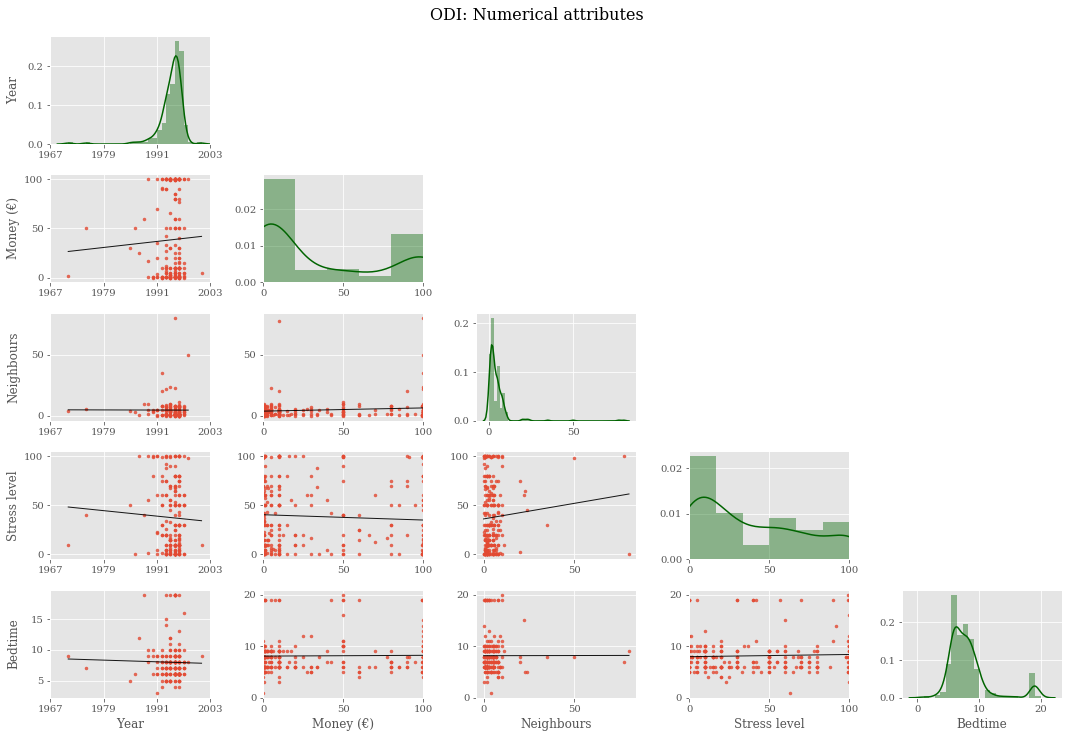

In [16]:
# data = pd.read_csv('ODI-2019-csv.csv', sep=';')
reload(util.plot)
reload(util.data)

util.plot.correlation_grid(data, numerical)
plt.suptitle('ODI: Numerical attributes', y=1.02, fontsize=16)
util.plot.savefig('Correlations-grid')

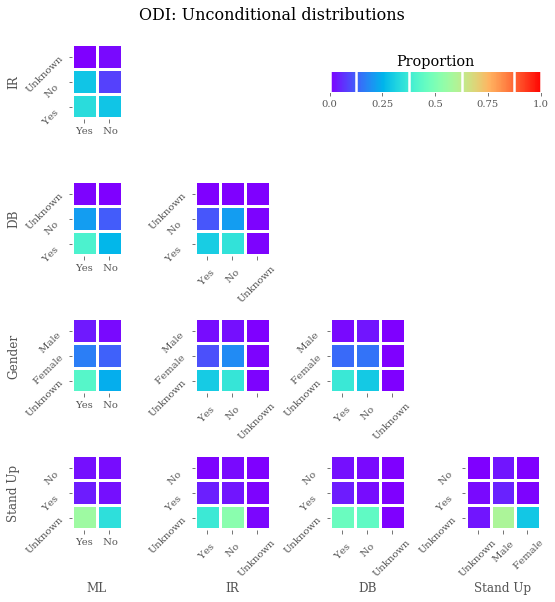

In [17]:
reload(util.plot)
reload(util.data)

cmap = 'rainbow'
keys = categorical.copy()
keys.remove('Chocolate')
keys.remove('Stat')
util.plot.correlation_grid(data, keys, numerical=False, cmap=cmap)
plt.suptitle('ODI: Unconditional distributions', y=1.04, fontsize=16)
util.plot.savefig('Unconditional-distributions-grid')

## Conditional distributions

I.e. the distribution of $Y$ given $X=x$ (for each $x$)

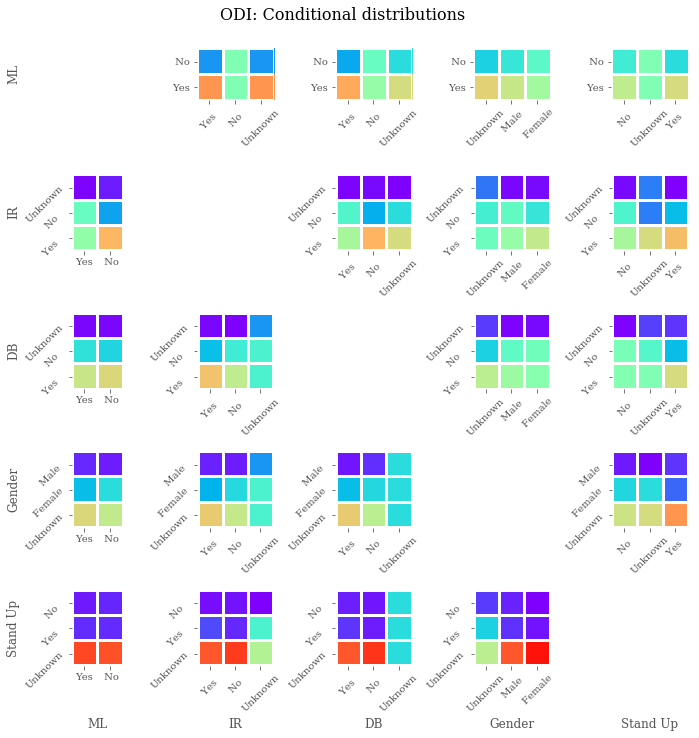

In [32]:
reload(util.plot)
reload(util.data)

keys = categorical.copy()
# keys.remove('ML')
keys.remove('Stat')
keys.remove('Chocolate')
util.plot.correlation_grid(data, keys, conditional_x=True, numerical=False, cmap=cmap)
plt.suptitle('ODI: Conditional distributions', y=1.02, fontsize=16)
util.plot.savefig('Conditional-distributions-grid')

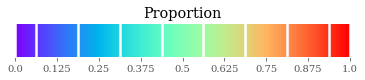

In [19]:
reload(util.plot)

with plt.style.context(('ggplot')):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    util.plot.colormap(cmap, ax, ratio=10, n_xticks=9)
    plt.title('Proportion')

util.plot.savefig('Conditional-distributions-grid-cb')

In [20]:
data = pd.read_csv('ODI-2019-clean.csv', sep=';')

In [21]:
# plot_correlations(data, categorical, conditional_x=True)
# plt.suptitle('Conditional distributions', fontsize=16)
# util.plot.savefig('Conditional-distributions-grid')

In [22]:
# data.Programme
# data.Programme.where(data.Programme.isin(keys))
# data.Programme[data.Programme.isin(['Other'])]

In [23]:
# reload(util.data)
key = 'Other'
most_common = util.data.select_most_common(data.Programme, n=8, key=key)
values = np.array(list(most_common.values()))
# note that pd.where different than np.where
keys = most_common.keys()
data.Programme.where(data.Programme.isin(keys), key, inplace=True)

for n in range(1,10):
    proportion = round(sum(values[:n]) / sum(values), n)
    print('%i best (cumulative): %0.2f' % (n, proportion*100) + '%')

1 best (cumulative): 30.00%
2 best (cumulative): 61.00%
3 best (cumulative): 72.10%
4 best (cumulative): 82.97%
5 best (cumulative): 88.77%
6 best (cumulative): 91.30%
7 best (cumulative): 93.12%
8 best (cumulative): 94.93%
9 best (cumulative): 100.00%


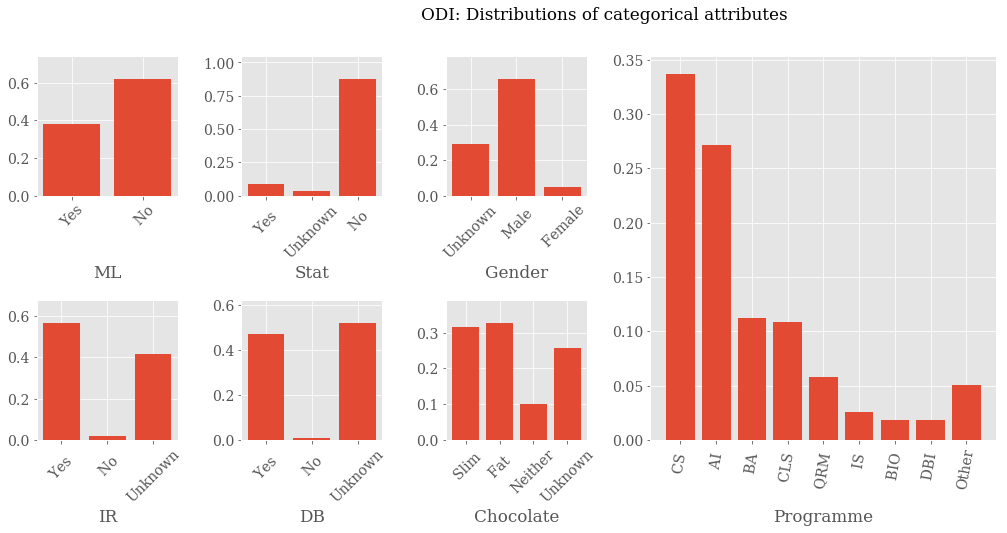

In [50]:
keys = categorical.copy()
keys.remove('Stand Up')
# n2 = len(keys)
# n = np.ceil(n2**0.5)
ij = lambda i,n: (np.floor(i/n), i % n)

with plt.style.context(('ggplot')):
    rcParams['font.size'] = 14
    m = 2
    n = 6
    n_minor = 3 # small plots form a 3x3 grid
    fig = plt.figure(figsize=(m*n+5,n+1))
    for i,k in enumerate(keys):
        assert i < m*n
        i,j = ij(i, m)
        i = i + j * n + 1
        ax = fig.add_subplot(m, n, i)
        counts = collections.Counter(data[k])
        title = k.title() if len(k) > 2 else k
        util.plot.categorical_distribution(counts, fig, title, label_func=lambda x: x.title())
        plt.xticks(rotation=45)
        plt.margins(y=0.2)

    ax = plt.subplot2grid( (m, n), (0, n_minor), rowspan=2, colspan=2)
    util.plot.categorical_distribution(most_common, fig, sort=False)
    plt.xticks(rotation=80)
    plt.xlabel('Programme')
    
    
    fig.align_labels()
    plt.tight_layout()
    plt.suptitle('ODI: Distributions of categorical attributes', y=1.06)

util.plot.savefig('odi-categorical-hist')

In [25]:
counts = collections.Counter(data["DB"])
counts, 3/sum(counts.values()) * 100

(Counter({'Yes': 143, 'No': 130, 'Unknown': 3}), 1.0869565217391304)

In [26]:
counts = collections.Counter(data["Stat"])
counts, 242/sum(counts.values()) * 100

(Counter({'Yes': 242, 'Unknown': 10, 'No': 24}), 87.68115942028986)

In [27]:
# programme = data['Programme'].copy()
# data.Programme = programme[~programme.isin(keys)] = "Other"

In [28]:
fn = 'ODI-2019-clean.pkl'
with open(fn, 'wb') as f:
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [29]:
# load (old) data from disk
with open(fn, 'rb') as f:
    data_cp = pickle.load(f)

In [30]:
# data_cp.head()

In [31]:
# X = np.random.random(size=(100,2))
# plt.scatter(X[:,0], X[:,1])
# plt.plot([0,1],[0,0.5])
# plt.plot([0,1],[0,0.8])